In [1]:
# General Imports
import os, sys
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, random_split, Dataset
sys.path.insert(0, '../')
from utils.fixes import global_seed

global_seed(42)
%matplotlib inline

Global seed set to 42


In [2]:
smifile = "250k_rndm_zinc_drugs_clean_3.csv"
data = pd.read_csv(smifile, delimiter = ",")
data = data.sample(n=10000, random_state=42)

In [3]:
data.head()

,smiles,logP,qed,SAS
100329,C[NH+]1CCC(NC(=O)[C@H]2CCN(c3ccc(Cl)c(Cl)c3)C2...,1.13960,0.793487,3.843395
12103,C[C@H]1C[C@H]1C(=O)N1CCN(C(=O)NCC(C)(C)[NH+]2C...,0.34360,0.784932,4.232355
170922,Cc1ccc([C@@H]2CSCCN2Cc2cc3cnn(C(C)C)c3nc2Cl)o1\n,4.85712,0.569373,3.463493
106167,C=CCc1ccccc1OC(C)=O\n,2.34040,0.401613,1.943724
33917,C[C@@H](c1nccs1)N(C)C(=O)c1cccc(NC(=O)C2CCCC2)...,4.10500,0.843003,2.639230


In [4]:
from gensim.models import word2vec
model = word2vec.Word2Vec.load("model_300dim.pkl")

In [5]:
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec

In [6]:
def sentences2vec(sentences, model, unseen=None):
    """Generate vectors for each sentence (list) in a list of sentences. Vector is simply a
    sum of vectors for individual words.

    Parameters
    ----------
    sentences : list, array
        List with sentences
    model : word2vec.Word2Vec
        Gensim word2vec model
    unseen : None, str
        Keyword for unseen words. If None, those words are skipped.
        https://stats.stackexchange.com/questions/163005/how-to-set-the-dictionary-for-text-analysis-using-neural-networks/163032#163032

    Returns
    -------
    np.array
    """

    keys = set(model.wv.key_to_index)
    vec = []

    if unseen:
        unseen_vec = model.wv.get_vector(unseen)

    for sentence in sentences:
        if unseen:
            vec.append(sum([model.wv.get_vector(y) if y in set(sentence) & keys
                       else unseen_vec for y in sentence]))
        else:
            vec.append(sum([model.wv.get_vector(y) for y in sentence
                            if y in set(sentence) & keys]))
    return np.array(vec)

In [7]:
data['mol'] = data['smiles'].apply(lambda x: Chem.MolFromSmiles(x))

In [8]:
data['mol_sentence'] = data.apply(lambda x: MolSentence(mol2alt_sentence(x['mol'], 1)), axis=1)

In [9]:
mol2vec = [DfVec(x) for x in sentences2vec(data['mol_sentence'], model, unseen='UNK')]

In [10]:
mol2vec = np.array([x.vec for x in mol2vec])

In [11]:
mol2vec.shape

(10000, 300)

In [12]:
split= {f'vec_{i}': mol2vec[:, i] for i in range(mol2vec.shape[1])}

In [13]:
vecs = pd.DataFrame(split)

In [14]:
vecs.head()

,vec_0,vec_1,vec_2,vec_3,vec_4,vec_5,vec_6,vec_7,vec_8,vec_9,...,vec_290,vec_291,vec_292,vec_293,vec_294,vec_295,vec_296,vec_297,vec_298,vec_299
0,3.208823,-5.493441,-0.632480,2.969938,-1.709260,-2.703460,-6.465906,0.068099,5.017220,3.797299,...,-0.595844,13.599172,5.314535,0.684511,-9.736329,-3.377924,-7.314924,-2.961603,-8.356824,-0.682712
1,2.888995,-4.475765,0.612710,-1.835744,0.046746,-4.164489,-9.017399,0.758894,4.410466,1.808888,...,1.148437,14.245388,2.996414,-1.776844,-11.532051,-4.027873,-7.868832,-4.985416,-9.727511,-3.052018
2,3.552563,-5.004806,-2.421398,6.093190,-0.032755,-0.418898,-11.129585,-3.851657,5.413703,-0.605405,...,0.347149,9.091203,7.962052,-4.259135,-8.317079,-2.657170,-7.707055,-3.809727,-12.471352,-1.650865
3,0.165621,-1.312819,-2.208296,2.237687,1.918152,0.087402,-6.112268,-0.603758,3.546045,1.658124,...,-0.307675,6.528207,5.010242,0.917328,-4.881955,-0.991636,-2.678632,-4.053768,-5.209335,-2.850917
4,-0.097131,-2.751795,-2.653869,3.741918,0.586031,-1.295714,-9.286900,0.541049,9.045529,2.363341,...,1.239658,12.163701,8.579157,0.459416,-7.516198,-4.572746,-7.003902,-6.383719,-11.703123,-0.850615


In [15]:
vecs['logP'] = data['logP'].values
vecs['smiles'] = data['smiles'].values

In [16]:
vecs

,vec_0,vec_1,vec_2,vec_3,vec_4,vec_5,vec_6,vec_7,vec_8,vec_9,...,vec_292,vec_293,vec_294,vec_295,vec_296,vec_297,vec_298,vec_299,logP,smiles
0,3.208823,-5.493441,-0.632480,2.969938,-1.709260,-2.703460,-6.465906,0.068099,5.017220,3.797299,...,5.314535,0.684511,-9.736329,-3.377924,-7.314924,-2.961603,-8.356824,-0.682712,1.13960,C[NH+]1CCC(NC(=O)[C@H]2CCN(c3ccc(Cl)c(Cl)c3)C2...
1,2.888995,-4.475765,0.612710,-1.835744,0.046746,-4.164489,-9.017399,0.758894,4.410466,1.808888,...,2.996414,-1.776844,-11.532051,-4.027873,-7.868832,-4.985416,-9.727511,-3.052018,0.34360,C[C@H]1C[C@H]1C(=O)N1CCN(C(=O)NCC(C)(C)[NH+]2C...
2,3.552563,-5.004806,-2.421398,6.093190,-0.032755,-0.418898,-11.129585,-3.851657,5.413703,-0.605405,...,7.962052,-4.259135,-8.317079,-2.657170,-7.707055,-3.809727,-12.471352,-1.650865,4.85712,Cc1ccc([C@@H]2CSCCN2Cc2cc3cnn(C(C)C)c3nc2Cl)o1\n
3,0.165621,-1.312819,-2.208296,2.237687,1.918152,0.087402,-6.112268,-0.603758,3.546045,1.658124,...,5.010242,0.917328,-4.881955,-0.991636,-2.678632,-4.053768,-5.209335,-2.850917,2.34040,C=CCc1ccccc1OC(C)=O\n
4,-0.097131,-2.751795,-2.653869,3.741918,0.586031,-1.295714,-9.286900,0.541049,9.045529,2.363341,...,8.579157,0.459416,-7.516198,-4.572746,-7.003902,-6.383719,-11.703123,-0.850615,4.10500,C[C@@H](c1nccs1)N(C)C(=O)c1cccc(NC(=O)C2CCCC2)...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,3.149517,-5.912338,-3.342572,5.063833,1.209950,1.450080,-8.835844,-2.422362,3.261962,0.181602,...,8.066936,-5.068615,-5.878430,-4.655751,-5.748816,-2.033437,-10.135429,-1.273553,2.95734,Cc1cc(NC(=O)c2cc(C3CC3)nc3onc(C)c23)on1\n
9996,0.866559,-5.617601,-2.084500,1.500934,0.414463,-0.230240,-11.030504,-1.679072,6.781714,0.316821,...,7.834716,0.742749,-9.184113,-3.480695,-4.664177,-6.158488,-10.926046,-3.834805,2.14680,CCCCNC(=O)c1ccc(CNC(=O)N2CCO[C@H](C)C2)cc1\n
9997,1.767921,-5.417960,-2.414780,5.429947,-0.234058,-2.773077,-10.402782,-2.301766,6.844529,4.105608,...,6.886694,-1.467427,-7.947645,-4.368306,-7.309598,-5.828468,-11.302728,-1.049029,3.84539,COc1ccc(-c2n[nH]c(=S)n2CC(=O)NC2CCCCCCC2)cc1\n
9998,0.796060,-5.421035,-0.334348,4.779342,-1.001768,-1.208561,-8.081294,-1.126442,9.446869,2.685735,...,9.897014,-0.473376,-6.800110,-1.895076,-5.264774,-3.981951,-8.188497,-1.878498,2.83350,C[C@H]1C[C@H]1NC(=O)NC[C@@H](c1ccc(Cl)cc1)n1cc...


In [17]:
def generate_mol_vector(mol):
    mol_sentence = MolSentence(mol2alt_sentence(mol, 1))
    print(mol_sentence)
    mol2vec = DfVec(sentences2vec(mol_sentence, model, unseen='UNK'))
    return mol2vec.vec

In [217]:
import time
CALLS = []
target = data['logP'].values
def get_score(id):
    global CALLS
    CALLS.append(id)
    time.sleep(1)
    return target[id]

In [234]:
from sklearn.neighbors import NearestNeighbors
import torch
import warnings
class ChemicalSpace:
    def __init__(self, file):
        if file.split('.')[-1] == 'csv':
            compounds = pd.read_csv(file, delimiter = ",")
            compounds = compounds.sample(n=1000, random_state=42)
        elif file.split('.')[-1] == 'smi':
            raise NotImplementedError
        else:
            raise NotImplementedError
        self.compounds = compounds
        self.compounds['mol'] = self.compounds['smiles'].apply(lambda x: Chem.MolFromSmiles(x))
        self.compounds['mol_sentence'] = self.compounds.apply(lambda x: MolSentence(mol2alt_sentence(x['mol'], 1)), axis=1)
        self.mol2vec = [DfVec(x) for x in sentences2vec(self.compounds['mol_sentence'], model, unseen='UNK')]
        self.mol2vec = np.array([x.vec for x in self.mol2vec])
        split = {f'vec_{i}': self.mol2vec[:, i] for i in range(self.mol2vec.shape[1])}
        self.vecs = pd.DataFrame(split)
        self.scores_cache = {}
    def init_knn(self, n_neighbors=5):
        self.nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(self.mol2vec)
    def get_neighbors(self, vec, return_distance=False):
        if len(vec.shape) == 1:
            vec = vec.reshape(1, -1)
        return self.nbrs.kneighbors(vec, return_distance=return_distance)
    def set_objective(self, objective, **kwargs):
        # objective is a function that takes in an id and returns a score
        self.objective = objective
        self.objective_kwargs = kwargs
    def get_objective(self, id):
        if id not in self.scores_cache:
            self.scores_cache[id] = self.objective(id, **self.objective_kwargs)
        return self.scores_cache[id]
    def f(self, X):
        # get neighbors
        if not isinstance(X, torch.Tensor):
            warnings.warn("X is not a torch tensor. Converting to torch tensor...")
            X = torch.tensor(X, dtype=torch.float, requires_grad=True)
        X_numpy = X.detach().numpy()
        neighbors = self.get_neighbors(X_numpy)[0]
        scores = torch.tensor([self.get_objective(i) for i in neighbors], dtype=torch.float, requires_grad=True)
        # get coordinates of neighbors
        coords = torch.tensor([self.mol2vec[i] for i in neighbors], dtype=torch.float, requires_grad=True)
        # f(x) = distance weighted average of neighbors
        # distance weighted average = sum of scores * (1 / distance)
        # distance = euclidean distance
        distance_sum = torch.sum(1 / torch.sqrt(torch.sum((coords - X)**2, axis=1)))
        scores = torch.sum(scores * (1 / torch.sqrt(torch.sum((coords - X)**2, axis=1)))) / distance_sum
        return torch.mean(scores)

In [235]:
space = ChemicalSpace(smifile)

In [236]:
space.mol2vec[0]

array([  3.2088232 ,  -5.493441  ,  -0.6324803 ,   2.9699378 ,
        -1.7092601 ,  -2.7034605 ,  -6.465906  ,   0.06809908,
         5.0172205 ,   3.7972991 ,   2.8689113 ,  -0.24366792,
        -8.980128  ,   2.529487  ,  -5.283301  ,  -2.500771  ,
         5.579712  ,  -4.1904416 ,  -5.890363  ,   4.8658047 ,
         3.981257  ,   5.2546687 ,  11.364352  ,   6.787876  ,
        -4.8181534 ,  -0.5364844 ,  -2.910465  ,  -9.695944  ,
         0.4568093 ,  -3.1330624 ,   7.0800548 ,  -4.961728  ,
        -4.967168  ,  -0.98072034,   2.4960344 ,   2.05174   ,
        -0.2487238 ,  -0.9815038 ,   8.816292  ,   5.6773067 ,
        -2.6589944 ,   0.8815095 ,  -1.3959906 ,  -3.3094823 ,
        -6.1085033 ,   7.2253914 ,  -0.8421392 ,   4.1921    ,
        -4.44603   ,   5.10548   ,   3.6305246 ,  -5.5423727 ,
         2.293107  ,  -4.763976  ,  -9.937673  ,  -5.9810557 ,
        -4.9783063 ,   4.4062524 ,   3.4497712 ,   7.6474233 ,
        -0.37825677,  -6.944269  ,  -4.3105426 ,   1.34

In [237]:
space.init_knn()

In [238]:
space.get_neighbors(space.mol2vec[7])

array([[  7, 844, 931, 433, 309]])

In [239]:
space.get_neighbors(space.mol2vec[844])

array([[844,   7, 433, 331, 127]])

In [240]:
space.set_objective(get_score)

In [241]:
space.get_objective(84)

4.1891

In [242]:
%%time
space.get_objective(8)

CPU times: user 1.81 ms, sys: 48 µs, total: 1.85 ms
Wall time: 1 s


3.87542

In [243]:
%%time
space.get_objective(8)

CPU times: user 9 µs, sys: 1 µs, total: 10 µs
Wall time: 15.7 µs


3.87542

In [244]:
debug_vector = torch.rand(300, requires_grad=True)

In [245]:
space.f(debug_vector)

tensor(0.7022, grad_fn=<MeanBackward0>)

In [246]:
from utils import *
global_seed(654)

Global seed set to 654


In [247]:
# optimize f(x)
X = torch.randn(300, requires_grad=True)

In [248]:
from torch.optim import Adam
optimizer = Adam([X], lr=10)

In [249]:
CALLS = []
best = 0
for i in range(1000):
    optimizer.zero_grad()
    loss = - space.f(X)
    loss.backward()
    optimizer.step()
    if space.f(X) > best:
        best = space.f(X).item()
    print(f'Iteration: {i}, Loss: {loss.item()}, Best: {best}, Neighbors: {space.get_neighbors(X.detach().numpy())[0]}')

Iteration: 0, Loss: -0.7021668553352356, Best: 1.98465096950531, Neighbors: [223 685 452 355 378]
Iteration: 1, Loss: -1.98465096950531, Best: 2.407794237136841, Neighbors: [804 846 452 670 927]
Iteration: 2, Loss: -2.407794237136841, Best: 2.9245827198028564, Neighbors: [ 44 804 846 922 145]
Iteration: 3, Loss: -2.9245827198028564, Best: 2.9251039028167725, Neighbors: [ 44 804 145 922 846]
Iteration: 4, Loss: -2.9251039028167725, Best: 2.9396719932556152, Neighbors: [ 44 145 804 922 375]
Iteration: 5, Loss: -2.9396719932556152, Best: 2.940211296081543, Neighbors: [145  44 922 804 375]
Iteration: 6, Loss: -2.940211296081543, Best: 2.9406299591064453, Neighbors: [145  44 375 922 804]
Iteration: 7, Loss: -2.9406299591064453, Best: 2.9409658908843994, Neighbors: [145 375  44 922 804]
Iteration: 8, Loss: -2.9409658908843994, Best: 2.9412434101104736, Neighbors: [145 375 922  44 804]
Iteration: 9, Loss: -2.9412434101104736, Best: 2.9414784908294678, Neighbors: [145 375 922  44 804]
Iteratio

In [250]:
from scipy.stats import percentileofscore
print(f'Visited {len(set(CALLS))} points')
print(f'Best score: {best}')
print(f'Percentile: {percentileofscore(target, best)}')

Visited 53 points
Best score: 5.369648456573486
Percentile: 99.51


In [67]:
lrs = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
lrs_timeline = {lr: [] for lr in lrs}
exploration_index = []

In [68]:
for lr in lrs:
    print(f'Learning rate: {lr}')
    global_seed(650)
    X = torch.randn(300, requires_grad=True)
    optimizer = Adam([X], lr=lr)
    CALLS = []
    for i in range(10000):
        optimizer.zero_grad()
        loss = f(X, nbrs)
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print(f'Iteration {i}: {f(X, nbrs)}')
            lrs_timeline[lr].append(f(X, nbrs).item())
    print(f'Visited {len(set(CALLS))} points')
    exploration_index.append(len(set(CALLS)))

Learning rate: 0.001
Global seed set to 650
Iteration 0: 1.7054604291915894
Iteration 100: 1.6967052221298218
Iteration 200: 1.6879926919937134
Iteration 300: 1.679275393486023
Iteration 400: 1.3359078168869019
Iteration 500: 1.3338439464569092
Iteration 600: 1.331728458404541
Iteration 700: 1.3295127153396606
Iteration 800: 1.3271727561950684
Iteration 900: 1.3246910572052002
Iteration 1000: 1.3220490217208862
Iteration 1100: 1.3192085027694702
Iteration 1200: 1.3161143064498901
Iteration 1300: 1.3127740621566772
Iteration 1400: 1.3091470003128052
Iteration 1500: 1.3814133405685425
Iteration 1600: 1.4543311595916748
Iteration 1700: 1.295851230621338
Iteration 1800: 1.3632317781448364
Iteration 1900: 1.4299498796463013
Iteration 2000: 1.3466798067092896
Iteration 2100: 1.4073575735092163
Iteration 2200: 1.324694037437439
Iteration 2300: 1.3111432790756226
Iteration 2400: 1.2955728769302368
Iteration 2500: 1.3396974802017212
Iteration 2600: 1.2581626176834106
Iteration 2700: 1.236734628

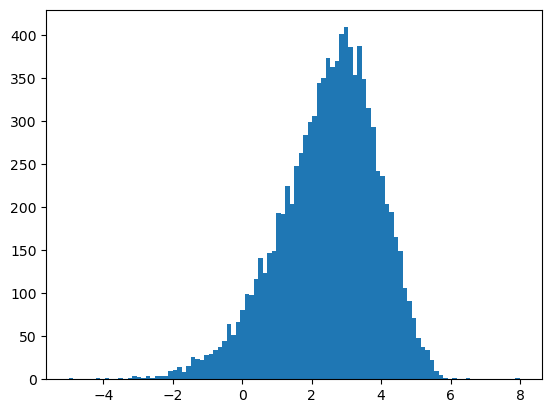

In [69]:
# plot learning rate vs exploration index
_ = plt.hist(vecs['logP'], bins=100)

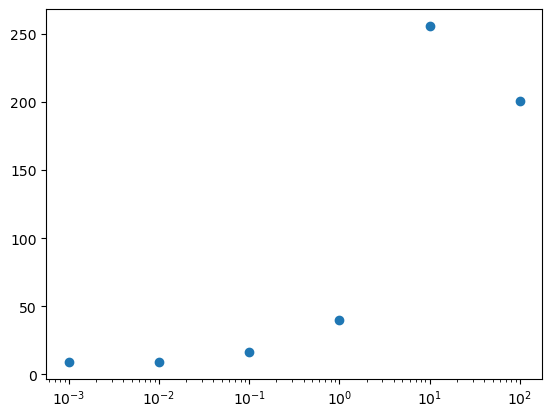

In [70]:
# plot learning rate vs exploration index plot in log scale
_ = plt.plot(lrs, exploration_index, 'o')
plt.xscale('log')

In [72]:
for lr in lrs:
    print(f'Best logP for lr={lr}: {np.min(lrs_timeline[lr])}')

Best logP for lr=0.001: 0.7648655772209167
Best logP for lr=0.01: 0.7652924656867981
Best logP for lr=0.1: -1.1461920738220215
Best logP for lr=1.0: -1.1242316961288452
Best logP for lr=10.0: -3.740234851837158
Best logP for lr=100.0: -3.3659591674804688


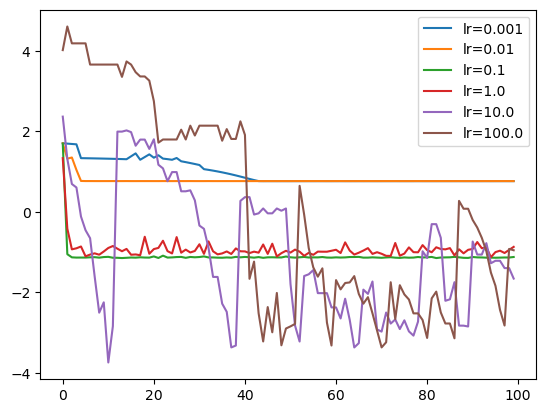

In [73]:
for lr in lrs:
    _ = plt.plot(lrs_timeline[lr], label=f'lr={lr}')
plt.legend()

In [74]:
from scipy import stats

In [76]:
#percentile of each best logP
for lr in lrs:
    print(f'Percentile of best logP for lr={lr}: {stats.percentileofscore(vecs["logP"], np.min(lrs_timeline[lr]))}')

Percentile of best logP for lr=0.001: 12.280000000000001
Percentile of best logP for lr=0.01: 12.280000000000001
Percentile of best logP for lr=0.1: 1.56
Percentile of best logP for lr=1.0: 1.61
Percentile of best logP for lr=10.0: 0.03
Percentile of best logP for lr=100.0: 0.04
